In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
import mlflow
import mlflow.sklearn
import optuna
from random import randint
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Base Models (+ ST assessor)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC#, SVR # kernels: 'linear', 'poly' e 'rbf'
from sklearn.neural_network import MLPClassifier
from kan import KANClassifier
from sklearn.ensemble import RandomForestClassifier#, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/pbsl/pog/IC - Reject Option/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json

with open('config.json', 'r') as f:
    CONFIG = json.load(f)

In [3]:
from train_models import *

In [4]:
def load_all_models(experiments:str|list, model_names:list=CONFIG['BASE_MODELS']) -> dict:
    models = {}

    if(isinstance(experiments, str)):
        experiments = [experiments]*len(model_names)
    else:
        if(len(experiments) != len(model_names)):
            raise ValueError('Variável "experiments" deve ser uma lista com tamanho igual à "models", ou ser apenas uma string')

    for i in range(len(model_names)):
        trained_model, _ = load_model_by_name(experiments[i], model_names[i])
        models[model_names[i]] = trained_model

    return models

In [21]:
from sklearn.pipeline import NotFittedError

class Pool():
    def __init__(self, models):
        self.predictors = models
        #self.keys = list(models.keys())
        #self.predict_cache = None
        #self.predict_proba_cache = None
        self.tree_based = ['Decision_Tree','Random_Forest','Gradient_Boosting','AdaBoost','XGBoost']
    
    def __len__(self):
        return len(self.predictors)

    def fit(self, X, X_norm, y):
        for name, model in self.predictors.items():
            try:
                _ = model.predict(X)
            except NotFittedError:
                if(name in self.tree_based):
                    model.fit(X,y)
                else:
                    model.fit(X_norm,y)
            print(f'{name} fitted.')
        
        return self

    def predict(self, X, X_norm):
        pred = pd.DataFrame(columns=list(self.predictors.keys()))
        for name, model in self.predictors.items():
            if(name in self.tree_based):
                pred[name] = model.predict(X)
            else:
                pred[name] = model.predict(X_norm)
        return pred

    def predict_proba(self, X, X_norm):
        pred = {}
        for name, model in self.predictors.items():
            if(name in self.tree_based):
                pred[name] = model.predict_proba(X)
            else:
                pred[name] = model.predict_proba(X_norm)
        return pred
    
    def drop(self, *args):
        new_models = {}
        for name, model in self.predictors.items():
            if(name not in args):
                new_models[name] = model
        newPool = Pool(new_models)
        return newPool

#class PoolRejector():
#    def __init__(self):
#        pass

In [22]:
from math import floor
from scipy import stats as st

class Rejector():
    def __init__(self, model_pool:Pool):
        self.predictors = model_pool
        self.cache_input = None
        self.cache_output_preds = None
        self.cache_output_proba = None

    def predictWithReject(self, X, X_norm, reject_rate, reject_method:str='avg'):
        # reject_method deve ser igual a 'avg', 'median', 'min' ou 'max'
        if(reject_method not in ['avg', 'mean', 'median', 'min','max']):
            raise ValueError("reject_method deve ser igual a 'avg', 'mean, 'median', 'min' ou 'max'")
        
        if(isinstance(X, pd.DataFrame)):
            X = X.to_numpy()
        if((X == self.cache_input).all() and (self.cache_output_proba.shape[1]==len(self.predictors))):
            predictions = self.cache_output_preds
            poolProb = self.cache_output_proba
        else:
            poolProb = pd.DataFrame()
            poolPreds = pd.DataFrame()
            results = self.predictors.predict_proba(X, X_norm)

            for name, probas in results.items():
                poolPreds[name] = np.argmax(probas, axis=1)
                poolProb[name] = 1 - np.max(probas, axis=1)

            predictions = pd.DataFrame(np.array(st.mode(poolPreds.values, axis=1))[0])

            self.cache_input = X
            self.cache_output_preds = predictions
            self.cache_output_proba = poolProb

        if(reject_method=='max'):
            predictions['score'] = poolProb.apply(lambda x: max(x), axis=1)
        elif(reject_method=='median'):
            predictions['score'] = poolProb.apply(lambda x: np.median(x), axis=1)
        elif(reject_method=='min'):
            predictions['score'] = poolProb.apply(lambda x: min(x), axis=1)
        else: #avg or mean
            predictions['score'] = poolProb.apply(lambda x: np.mean(x), axis=1)

        if(reject_rate > 1):
            reject_rate = reject_rate/100

        n_reject = floor(poolProb.shape[0] * reject_rate)
        if(n_reject==0):
            print('Warning: Number of rejections equals 0. Increase the rejection rate.')
        elif(n_reject==poolProb.shape[0]):
            print('Warning: All examples will be rejected. Decrease the rejection rate.')

        predictions = predictions.sort_values(by='score', ascending=False)
        predictions.iloc[:n_reject, :] = np.nan # REJECTED
        predictions = predictions.drop(columns=['score']).sort_index()

        return predictions[0]

- **Versões:**
  - v0: Versão inicial. Sem assessores. Apenas cálculo de confiança para rejeição por meio da probabilidade de classe dos modelos.

# TWO MOONS

In [7]:
#from train_models import experiment_name

experiment_name = getExpName('twomoons')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/494908295467387025', creation_time=1759707535932, experiment_id='494908295467387025', last_update_time=1759707535932, lifecycle_stage='active', name='twomoons_v0_1246495320', tags={}>

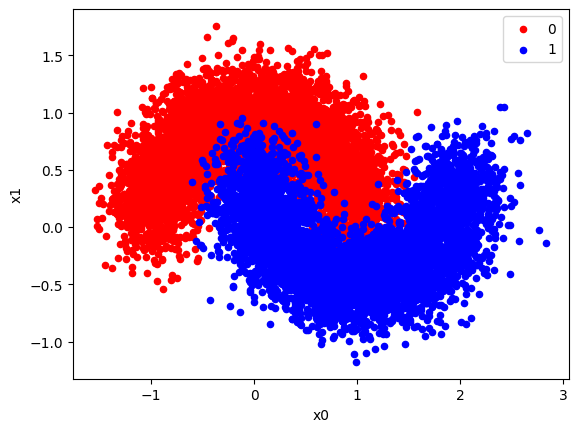

In [8]:
# generate 2d classification dataset
X, y = make_moons(n_samples=CONFIG['TWO_MOONS']['N_SAMPLES'], 
                  noise=CONFIG['TWO_MOONS']['NOISE'], 
                  random_state=CONFIG['SEED'])
df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [9]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('twomoons')

In [10]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

937a626718cd4a9f80529c1aa5a49a11


3977094c807a417b90e947f9bb3ef35f


81fbbd13b2304d2f87a9ce4813ff0e9f


330bc02845f148788f1447fc74f84843


081ad4a8935649918e70027ba965da1d


5b66802190ec435196842f88905f9ee7


4957b9df8f40411d8bfca7a2e72e056c


77203a99e6484c18a331f89c8dde817b


4e2c1460d7134cc090f47db3917c9b38


4581e75635e5404ca6cc79d0b1c8b10c


8634629504dd41bf9cdf22cfb76d9df7


f3150119303b475181e4f9964d95e692


In [11]:
modelPool = Pool(models)
y_pred_proba = modelPool.predict_proba(X_test, X_test_norm)
y_pred_proba

{'Decision_Tree': array([[0.        , 1.        ],
        [0.07142857, 0.92857143],
        [0.        , 1.        ],
        ...,
        [1.        , 0.        ],
        [0.        , 1.        ],
        [1.        , 0.        ]], shape=(3000, 2)),
 'SGD': array([[0.35777328, 0.64222672],
        [0.14683902, 0.85316098],
        [0.11679206, 0.88320794],
        ...,
        [0.93240344, 0.06759656],
        [0.        , 1.        ],
        [1.        , 0.        ]], shape=(3000, 2)),
 'Logistic_Regression': array([[0.22978403, 0.77021597],
        [0.04467509, 0.95532491],
        [0.03492969, 0.96507031],
        ...,
        [0.93228475, 0.06771525],
        [0.0096603 , 0.9903397 ],
        [0.96120558, 0.03879442]], shape=(3000, 2)),
 'KNN': array([[0.04761905, 0.95238095],
        [0.0952381 , 0.9047619 ],
        [0.04761905, 0.95238095],
        ...,
        [1.        , 0.        ],
        [0.        , 1.        ],
        [1.        , 0.        ]], shape=(3000, 2)),
 '

In [12]:
pred_reject = Rejector(modelPool)
y_pred = pred_reject.predictWithReject(X_test, X_test_norm, 0.2, 'avg')
y_pred

0       1.0
1       1.0
2       1.0
3       1.0
4       0.0
       ... 
2995    NaN
2996    1.0
2997    0.0
2998    1.0
2999    0.0
Name: 0, Length: 3000, dtype: float64

In [13]:
predictions = pred_reject.cache_output_preds
poolProb = pred_reject.cache_output_proba

predictions['score'] = poolProb.apply(lambda x: np.mean(x), axis=1)

n_reject = floor(poolProb.shape[0] * 0.2)
if(n_reject==0):
    print('Warning: Number of rejections equals 0. Increase the rejection rate.')
elif(n_reject==poolProb.shape[0]):
    print('Warning: All examples will be rejected. Decrease the rejection rate.')

predictions = predictions.sort_values(by='score', ascending=False)
#predictions.iloc[:n_reject, :] = np.nan # REJECTED
#predictions = predictions.drop(columns=['score']).sort_index()
predictions

,0,score
322,0,0.416293
73,0,0.415195
827,0,0.413340
598,1,0.412127
1528,1,0.411203
...,...,...
1406,1,0.032578
1485,0,0.032547
2093,1,0.031832
2440,1,0.031805


In [23]:
pred_reject = Rejector(modelPool)
results_log = pd.DataFrame(columns=['Method','Rejection Rate','Accuracy','Precision','Recall','F1-Score'])

for method in ['avg','median','min','max']:
    #score = {'avg':[],'median':[],'min':[],'max':[]}
    for reject_rate in range(5,96,5):
        y_pred = pred_reject.predictWithReject(X_test, X_test_norm, reject_rate, method)
        idx = y_pred.dropna().index
        acc = accuracy_score(y_test[idx], y_pred[idx])
        pre = precision_score(y_test[idx], y_pred[idx], zero_division=0)
        rec = recall_score(y_test[idx], y_pred[idx], zero_division=0)
        f1s = f1_score(y_test[idx], y_pred[idx], zero_division=0)
        results_log.loc[results_log.shape[0]] = [method,reject_rate*0.01,acc,pre,rec,f1s]

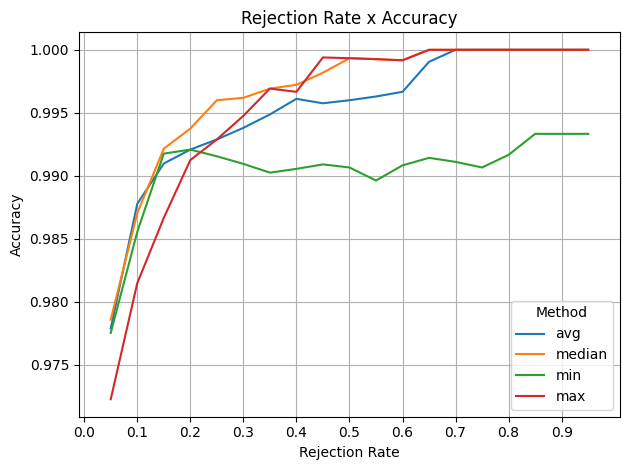

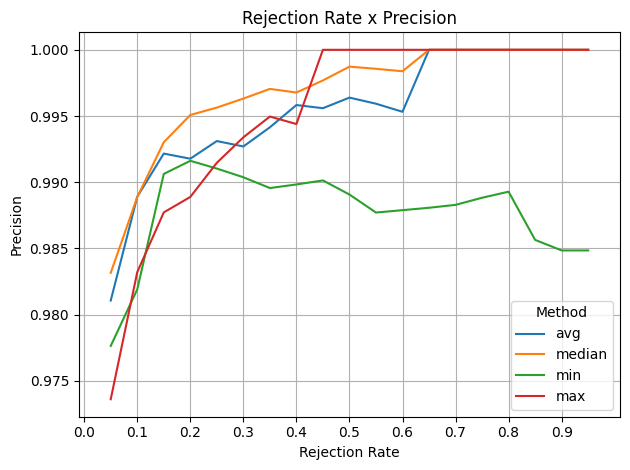

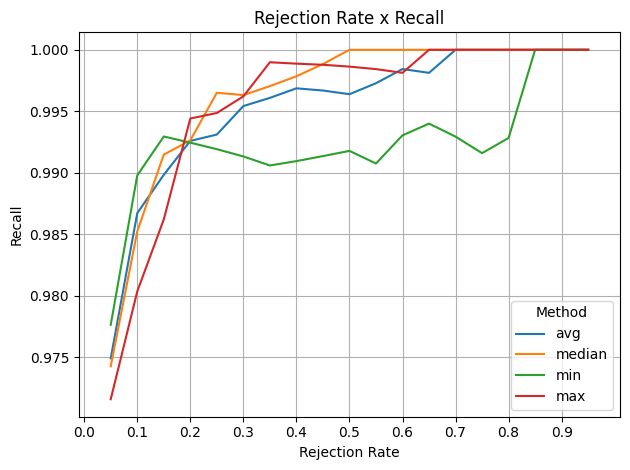

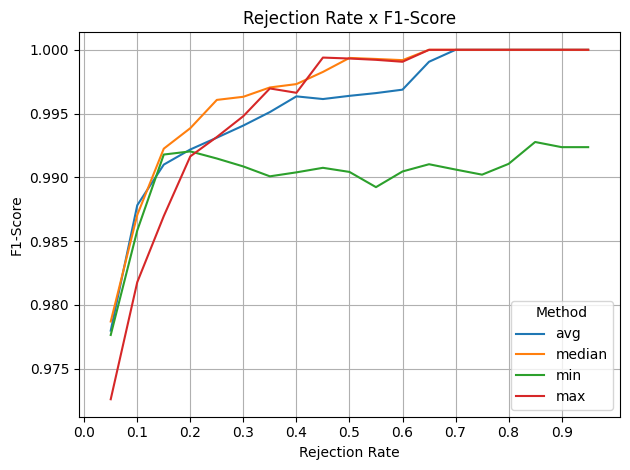

In [24]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [25]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.896
Method: median 	 |  Score: 0.897
Method: min 	 |  Score: 0.892
Method: max 	 |  Score: 0.896


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.05,0.977895,0.981066,0.974913,0.977980,0.896062
1,avg,0.10,0.987778,0.988905,0.986716,0.987809,0.896062
2,avg,0.15,0.990980,0.992163,0.989836,0.990998,0.896062
3,avg,0.20,0.992083,0.991776,0.992593,0.992184,0.896062
4,avg,0.25,0.992889,0.993109,0.993109,0.993109,0.896062
...,...,...,...,...,...,...,...
71,max,0.75,1.000000,1.000000,1.000000,1.000000,0.896197
72,max,0.80,1.000000,1.000000,1.000000,1.000000,0.896197
73,max,0.85,1.000000,1.000000,1.000000,1.000000,0.896197
74,max,0.90,1.000000,1.000000,1.000000,1.000000,0.896197


In [26]:
results_log.to_csv('results/twomoons_V0.csv')

# CIRCLES

In [27]:
#from train_models import experiment_name

experiment_name = getExpName('circles')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/176240900034942238', creation_time=1761054139569, experiment_id='176240900034942238', last_update_time=1761054139569, lifecycle_stage='active', name='circles_v0_1246495320', tags={}>

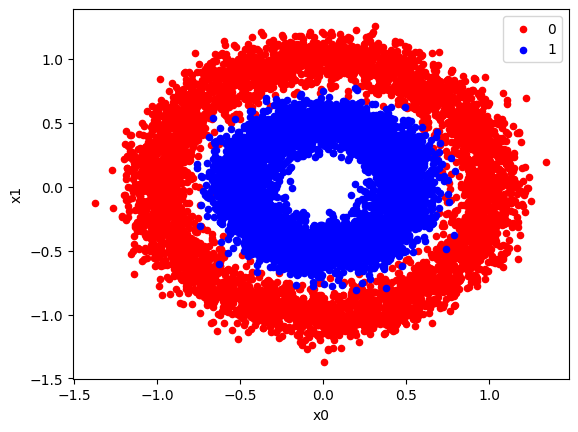

In [28]:
X, y = make_circles(n_samples=int(CONFIG['CIRCLES']['N_SAMPLES']/1), 
                            noise=CONFIG['CIRCLES']['NOISE'], 
                            factor=CONFIG['CIRCLES']['FACTOR'],
                            random_state=CONFIG['SEED'])

df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [29]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

865188b0261944d793cdf0498d361b9f


ef02d282cb4d40319ba4377dff7bb0da


83e6b099baac48d79ac7643ce73694f9


69926aa6dc2c4795871f2ea72127398d


86908d7fe54a474cb233766b9a8d01f8


5469993a3dfa469eb2cddecff60368f5


6eb0aa153584430bad70324b2e915f0f


d810ec65dda641a0bd2396fa4326d094


3b1187244862432dbeaa083e81d2c124


a9451bef3b554924b8c5115cfb0624a3


9096ac19b4e24ff5adff1800d6a28461


d0eea025a64f4c12b59b5a1842650dd0


In [31]:
modelPool = Pool(models)
X_train_c, X_train_norm_c, X_test_c, X_test_norm_c, y_train_c, y_test_c = get_data('circles')
pred_reject = Rejector(modelPool)
y_pred = pred_reject.predictWithReject(X_test_c, X_test_norm_c, 0.2, 'avg')
y_pred

0       1.0
1       1.0
2       1.0
3       1.0
4       0.0
       ... 
2995    1.0
2996    1.0
2997    NaN
2998    1.0
2999    0.0
Name: 0, Length: 3000, dtype: float64

In [32]:
predictions = pred_reject.cache_output_preds
poolProb = pred_reject.cache_output_proba

predictions['score'] = poolProb.apply(lambda x: np.mean(x), axis=1)

n_reject = floor(poolProb.shape[0] * 0.2)
if(n_reject==0):
    print('Warning: Number of rejections equals 0. Increase the rejection rate.')
elif(n_reject==poolProb.shape[0]):
    print('Warning: All examples will be rejected. Decrease the rejection rate.')

predictions = predictions.sort_values(by='score', ascending=False)
#predictions.iloc[:n_reject, :] = np.nan # REJECTED
#predictions = predictions.drop(columns=['score']).sort_index()
predictions

,0,score
1565,0,0.431470
494,0,0.429877
2163,0,0.425283
1311,0,0.411330
203,0,0.409013
...,...,...
2317,0,0.149653
330,0,0.149599
1398,0,0.149578
2570,0,0.149477


In [33]:
pred_reject = Rejector(modelPool)
results_log = pd.DataFrame(columns=['Method','Rejection Rate','Accuracy','Precision','Recall','F1-Score'])

for method in ['avg','median','min','max']:
    #score = {'avg':[],'median':[],'min':[],'max':[]}
    for reject_rate in range(5,96,5):
        y_pred = pred_reject.predictWithReject(X_test_c, X_test_norm_c, reject_rate, method)
        idx = y_pred.dropna().index
        acc = accuracy_score(y_test_c[idx], y_pred[idx])
        pre = precision_score(y_test_c[idx], y_pred[idx], zero_division=0)
        rec = recall_score(y_test_c[idx], y_pred[idx], zero_division=0)
        f1s = f1_score(y_test_c[idx], y_pred[idx], zero_division=0)
        results_log.loc[results_log.shape[0]] = [method,reject_rate*0.01,acc,pre,rec,f1s]

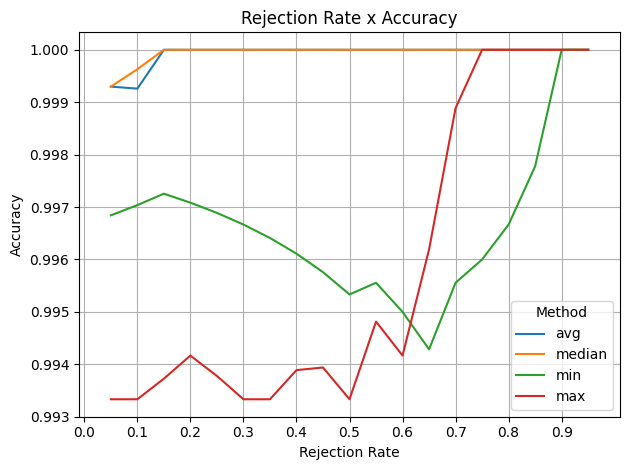

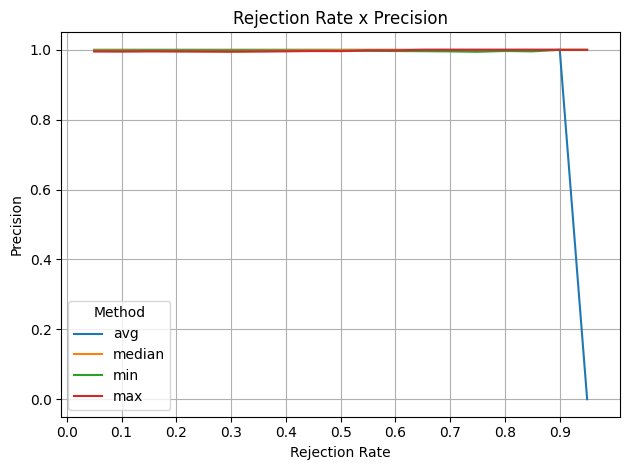

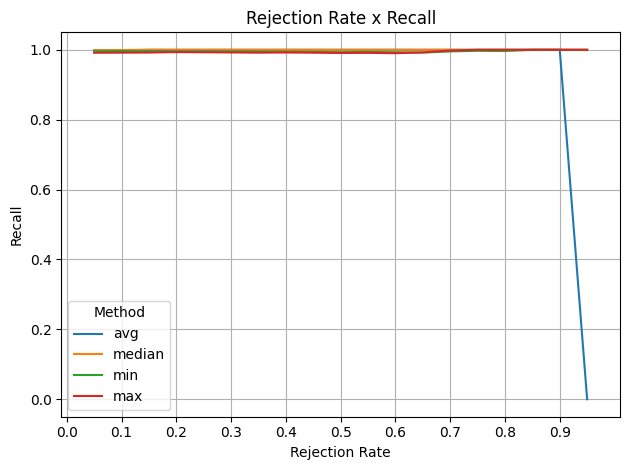

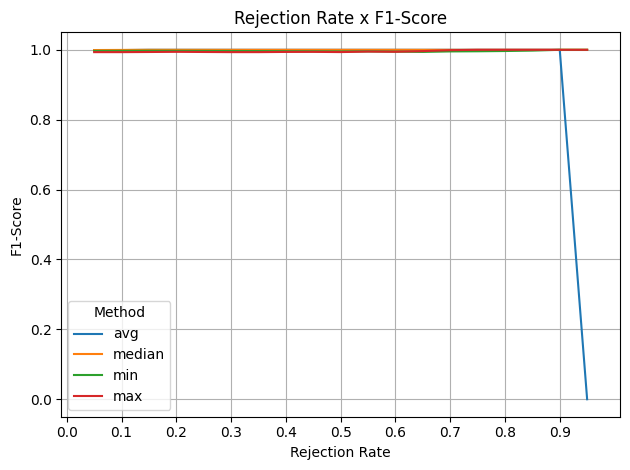

In [34]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [35]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.900
Method: median 	 |  Score: 0.900
Method: min 	 |  Score: 0.897
Method: max 	 |  Score: 0.896


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.05,0.999298,1.0,0.998601,0.999300,0.899945
1,avg,0.10,0.999259,1.0,0.998519,0.999259,0.899945
2,avg,0.15,1.000000,1.0,1.000000,1.000000,0.899945
3,avg,0.20,1.000000,1.0,1.000000,1.000000,0.899945
4,avg,0.25,1.000000,1.0,1.000000,1.000000,0.899945
...,...,...,...,...,...,...,...
71,max,0.75,1.000000,1.0,1.000000,1.000000,0.896178
72,max,0.80,1.000000,1.0,1.000000,1.000000,0.896178
73,max,0.85,1.000000,1.0,1.000000,1.000000,0.896178
74,max,0.90,1.000000,1.0,1.000000,1.000000,0.896178


In [36]:
results_log.to_csv('results/circles_V0.csv')

# AIRBNB

In [37]:
experiment_name = getExpName('airbnb')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/504386116767894917', creation_time=1760128217330, experiment_id='504386116767894917', last_update_time=1760128217330, lifecycle_stage='active', name='airbnb_v0_1246495320', tags={}>

In [38]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('airbnb')

In [39]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

57307f00799a49f891c3d5879123be6c


337057925ba34619a9bb81ed2fcb7a94


cd14dd0a07ae4ed2b6a8e035da6dcdbe


6bf1f8b02dae4cfa90006313ae7e1b5b


78263e20a35d46ba93f9b0bed051a4ee


30c0c01ed88d4a67824e69945bdd0a32


489829756440401cb4b763f41c9c9c32


69bc02563ab24af08e6e40ac8dffaf90


07a98b2ace084e4f833b308deb38664c


f56a84af216040f798fd6a53c1245667


55a1b97aac0144d0822d1ff36b555fe9


6ba1b13dfb42492bb170a458c6efd127


In [40]:
modelPool = Pool(models)
pred_reject = Rejector(modelPool)

results_log = pd.DataFrame(columns=['Method','Rejection Rate','Accuracy','Precision','Recall','F1-Score'])

for method in ['avg','median','min','max']:
    #score = {'avg':[],'median':[],'min':[],'max':[]}
    for reject_rate in range(5,96,5):
        y_pred = pred_reject.predictWithReject(X_test.values, X_test_norm, reject_rate, method)
        idx = y_pred.dropna().index
        acc = accuracy_score(y_test.to_numpy()[idx], y_pred[idx])
        pre = precision_score(y_test.to_numpy()[idx], y_pred[idx], zero_division=0)
        rec = recall_score(y_test.to_numpy()[idx], y_pred[idx], zero_division=0)
        f1s = f1_score(y_test.to_numpy()[idx], y_pred[idx], zero_division=0)
        results_log.loc[results_log.shape[0]] = [method,reject_rate*0.01,acc,pre,rec,f1s]

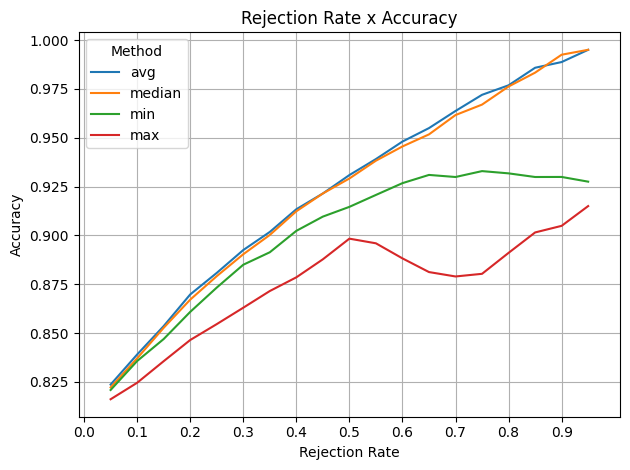

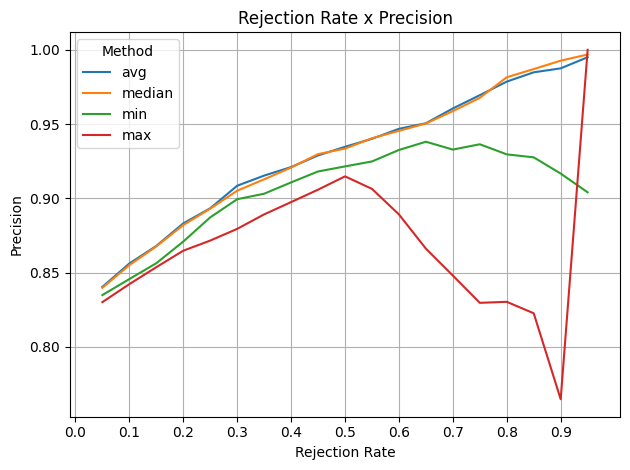

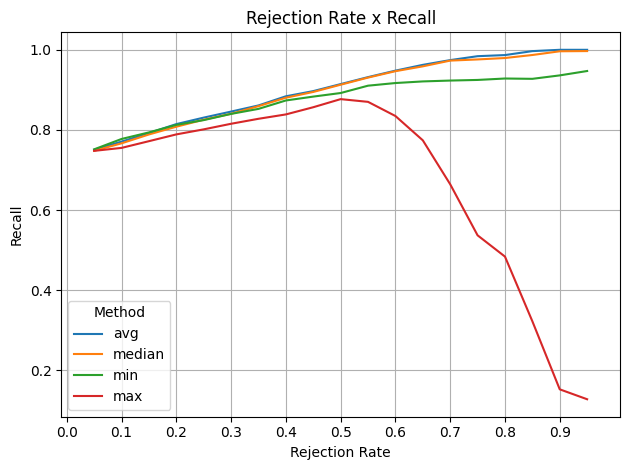

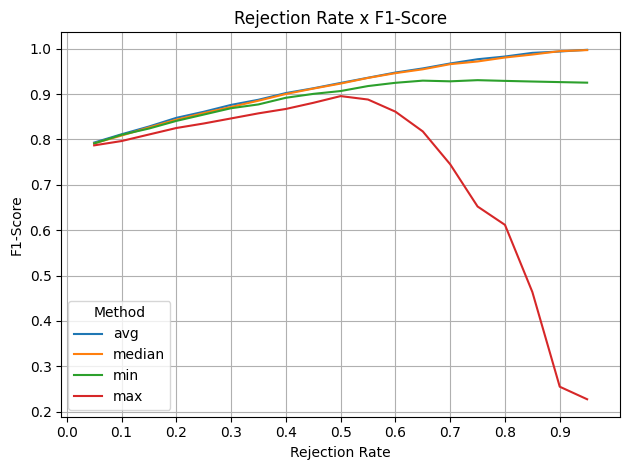

In [45]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [46]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.832
Method: median 	 |  Score: 0.831
Method: min 	 |  Score: 0.811
Method: max 	 |  Score: 0.787


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.05,0.823622,0.840380,0.750805,0.793071,0.832071
1,avg,0.10,0.839015,0.856110,0.770924,0.811287,0.832071
2,avg,0.15,0.853565,0.867945,0.792272,0.828384,0.832071
3,avg,0.20,0.869756,0.883117,0.814658,0.847507,0.832071
4,avg,0.25,0.880781,0.893290,0.830827,0.860927,0.832071
...,...,...,...,...,...,...,...
71,max,0.75,0.880320,0.829630,0.537170,0.652111,0.787393
72,max,0.80,0.891046,0.830303,0.484099,0.611607,0.787393
73,max,0.85,0.901503,0.822581,0.322785,0.463636,0.787393
74,max,0.90,0.904881,0.764706,0.152941,0.254902,0.787393


In [47]:
results_log.to_csv('results/airbnb_V0.csv')